In [1]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rich.progress import track
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import MaxAbsScaler

In [2]:
def parse_files(root_path):
    """
    Parse files and use pd.json_normalize to flatten the json.
    """
    files = root_path.joinpath("./train-output").glob("**/*.json")
    results = pd.DataFrame()
    files = list(files)

    for file in track(
        files,
        description="Loading hyperparameters and "
        "performance data from file to DataFrame",
    ):
        with open(file) as f:
            data = json.load(f)
            original_target = root_path.joinpath(data["original_target"])
            original_dict = json.loads(Path(original_target).read_text())

            f1_scores = pd.json_normalize(data, "f1_scores")
            normalized_data = pd.json_normalize(original_dict)
            normalized_data = pd.concat(
                [normalized_data] * len(f1_scores), ignore_index=True
            )
            normalized_data["metrics.f1_score"] = f1_scores
            normalized_data["paths.model_path"] = data["model_path"]
            results = pd.concat([results, normalized_data])
    # results = results.drop(columns=results.columns[results.columns.str.contains('hyperparameters')])
    results = results.set_index(
        ["percentage", "model", "use_gradient", "use_ewma"]
    )  # , 'alpha', 'hidden_layer_sizes', 'kernel', 'learning_rate', 'max_depth', 'n_estimators'])
    results.columns = pd.MultiIndex.from_arrays(
        zip(*results.columns.str.split(".", expand=True))
    )
    results = results.sort_index(axis=1)
    results = results.drop(columns=['k_fold', 'preprocessing'])
    results = results.droplevel(0, axis=1)

    return results


data_flattened = parse_files(Path("./analysis/"))
data_flattened

Output()

C  alpha hidden_layer_sizes kernel  \
percentage model use_gradient use_ewma                                         
4          SVM   True         False     1.0    NaN                NaN    rbf   
                              False     1.0    NaN                NaN    rbf   
                              False     1.0    NaN                NaN    rbf   
                              False     1.0    NaN                NaN    rbf   
                              False     1.0    NaN                NaN    rbf   
...                                     ...    ...                ...    ...   
19         LR    False        False     1.0    NaN                NaN    NaN   
                              False     1.0    NaN                NaN    NaN   
                              False     1.0    NaN                NaN    NaN   
                              False     1.0    NaN                NaN    NaN   
                              False     1.0    NaN                NaN    NaN   

                                        learning_rate  max_depth  \
percentage model use_gradient use_ewma                             
4          SVM   True         False               NaN        NaN   
                              False               NaN        NaN   
                              False               NaN        NaN   
                              False               NaN        NaN   
                              False               NaN        NaN   
...                                               ...        ...   
19         LR    False        False               NaN        NaN   
                              False               NaN        NaN   
                              False               NaN        NaN   
                              False               NaN        NaN   
                              False               NaN        NaN   

                                        n_estimators  f1_score  \
percentage model use_gradient use_ewma                           
4          SVM   True         False              NaN  0.737864   
                              False              NaN  0.687500   
                              False              NaN  0.744681   
                              False              NaN  0.696629   
                              False              NaN  0.760000   
...                                              ...       ...   
19         LR    False        False              NaN  0.565217   
                              False              NaN  0.549020   
                              False              NaN  0.650000   
                              False              NaN  0.461538   
                              False              NaN  0.478261   

                                                                            model_path  
percentage model use_gradient use_ewma                                                  
4          SVM   True         False        train-output/SVM_4_grad_no-ewma_3/model.pkl  
                              False        train-output/SVM_4_grad_no-ewma_3/model.pkl  
                              False        train-output/SVM_4_grad_no-ewma_3/model.pkl  
                              False        train-output/SVM_4_grad_no-ewma_3/model.pkl  
                              False        train-output/SVM_4_grad_no-ewma_3/model.pkl  
...                                                                                ...  
19         LR    False        False     train-output/LR_19_no-grad_no-ewma_1/model.pkl  
                              False     train-output/LR_19_no-grad_no-ewma_1/model.pkl  
                              False     train-output/LR_19_no-grad_no-ewma_1/model.pkl  
                              False     train-output/LR_19_no-grad_no-ewma_1/model.pkl  
                              False     train-output/LR_19_no-grad_no-ewma_1/model.pkl  

[33540 rows x 9 columns]

In [3]:
# Remove any runs that included use_ewma or use_gradient
df = data_flattened.loc[(slice(None), slice(None), False, False), :]
df.index = df.index.droplevel([2, 3])
df = df.sort_values(by=['percentage', 'model'])
df

C  alpha hidden_layer_sizes  kernel  learning_rate  \
percentage model                                                            
1          AdaBoost  NaN    NaN                NaN     NaN            0.1   
           AdaBoost  NaN    NaN                NaN     NaN            0.1   
           AdaBoost  NaN    NaN                NaN     NaN            0.1   
           AdaBoost  NaN    NaN                NaN     NaN            0.1   
           AdaBoost  NaN    NaN                NaN     NaN            0.1   
...                  ...    ...                ...     ...            ...   
20         SVM       0.1    NaN                NaN  linear            NaN   
           SVM       0.1    NaN                NaN  linear            NaN   
           SVM       0.1    NaN                NaN  linear            NaN   
           SVM       0.1    NaN                NaN  linear            NaN   
           SVM       0.1    NaN                NaN  linear            NaN   

                     max_depth  n_estimators  f1_score  \
percentage model                                         
1          AdaBoost        NaN          50.0  0.832000   
           AdaBoost        NaN          50.0  0.758065   
           AdaBoost        NaN          50.0  0.774194   
           AdaBoost        NaN          50.0  0.773109   
           AdaBoost        NaN          50.0  0.772727   
...                        ...           ...       ...   
20         SVM             NaN           NaN  0.400000   
           SVM             NaN           NaN  0.270270   
           SVM             NaN           NaN  0.434783   
           SVM             NaN           NaN  0.592593   
           SVM             NaN           NaN  0.415094   

                                                            model_path  
percentage model                                                        
1          AdaBoost  train-output/AdaBoost_1_no-grad_no-ewma_0/mode...  
           AdaBoost  train-output/AdaBoost_1_no-grad_no-ewma_0/mode...  
           AdaBoost  train-output/AdaBoost_1_no-grad_no-ewma_0/mode...  
           AdaBoost  train-output/AdaBoost_1_no-grad_no-ewma_0/mode...  
           AdaBoost  train-output/AdaBoost_1_no-grad_no-ewma_0/mode...  
...                                                                ...  
20         SVM         train-output/SVM_20_no-grad_no-ewma_0/model.pkl  
           SVM         train-output/SVM_20_no-grad_no-ewma_0/model.pkl  
           SVM         train-output/SVM_20_no-grad_no-ewma_0/model.pkl  
           SVM         train-output/SVM_20_no-grad_no-ewma_0/model.pkl  
           SVM         train-output/SVM_20_no-grad_no-ewma_0/model.pkl  

[8600 rows x 9 columns]

In [4]:
def float_or_list_to_tuple(x):
    if isinstance(x, list):
        return tuple(x)
    return x

df["hidden_layer_sizes"] = df['hidden_layer_sizes'].apply(float_or_list_to_tuple)

In [5]:
group = df.groupby(['percentage', 'model', 'C', 'hidden_layer_sizes', 'kernel', 'learning_rate', 'max_depth', 'n_estimators', 'alpha'], dropna=False)
summary = group['f1_score'].agg(['mean', 'std'])

idx = summary.groupby(['percentage', 'model']).idxmax()

best_hyperparams = summary.loc[idx['mean'], :]
best_per_percentage = best_hyperparams.groupby('percentage')['mean'].idxmax()
selected_percentages = best_hyperparams[best_hyperparams.index.get_level_values('percentage').isin([5, 10, 15, 20]) & best_hyperparams.index.get_level_values('model').isin(['RF', 'ET'])]
models_to_test = selected_percentages.droplevel(['C', 'hidden_layer_sizes', 'kernel', 'learning_rate', 'alpha'])
models_to_test


mean       std
percentage model max_depth n_estimators                    
5          ET    NaN       200.0         0.838747  0.042812
           RF    10.0      100.0         0.846744  0.041149
10         ET    NaN       50.0          0.799463  0.033741
           RF    20.0      100.0         0.808705  0.065661
15         ET    NaN       100.0         0.756114  0.053723
           RF    NaN       200.0         0.742610  0.064443
20         ET    20.0      50.0          0.717156  0.072528
           RF    10.0      100.0         0.707643  0.049374

In [6]:
random_state = 42
classifiers = {}
for percentage, model, max_depth, n_estimators in models_to_test.index:
    if np.isnan(max_depth):
        max_depth = None
    else:
        max_depth = int(max_depth)
    n_estimators = int(n_estimators)
    if model == 'ET':
        classifiers[(percentage, model)] = ExtraTreesClassifier(max_depth=max_depth, n_estimators=n_estimators, random_state=random_state, class_weight='balanced')
    elif model == 'RF':
        classifiers[(percentage, model)] = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators, random_state=random_state, class_weight='balanced_subsample')
classifiers

{(5,
  'ET'): ExtraTreesClassifier(class_weight='balanced', n_estimators=200, random_state=42),
 (5,
  'RF'): RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                        random_state=42),
 (10,
  'ET'): ExtraTreesClassifier(class_weight='balanced', n_estimators=50, random_state=42),
 (10,
  'RF'): RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                        random_state=42),
 (15, 'ET'): ExtraTreesClassifier(class_weight='balanced', random_state=42),
 (15,
  'RF'): RandomForestClassifier(class_weight='balanced_subsample', n_estimators=200,
                        random_state=42),
 (20,
  'ET'): ExtraTreesClassifier(class_weight='balanced', max_depth=20, n_estimators=50,
                      random_state=42),
 (20,
  'RF'): RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                        random_state=42)}

In [7]:
import pickle

def preprocess(dataframe):
    result, mzn = dataframe.drop(columns=['mzn', 'dzn'], axis=1), dataframe['mzn']

    # Drop any columns that contain the text 'ewma' or 'gradient'
    result = result.drop(columns=result.columns[result.columns.str.contains('ewma|gradient')], axis=1)

    result = result.drop(result.columns[result.nunique() == 1], axis=1)

    transformer = MaxAbsScaler().fit(result)
    result = pd.DataFrame(transformer.transform(result), columns=result.columns, index=result.index)

    result['mzn'] = mzn

    return result

train_pkl = Path('./analysis/pickle_split_train.pkl')

with open(train_pkl, 'rb') as f:
    train_features_at_percentage = pickle.load(f)

for percentage, model in classifiers:
    print(f"Training {model} at {percentage}%")
    df: pd.DataFrame = preprocess(train_features_at_percentage[percentage])
    df = df.drop(columns=['mzn'], axis=1)
    any_nan = df.isna().any().any()
    which_nan = df.isna().any(axis=1)
    print(f"Are there any NaN values in the dataset? {'Yes.' if any_nan else 'No.'} There are {which_nan.sum()} NaN values in the dataset.")
    if any_nan:
        print("The NaN values are in the following columns:")
        print(df.columns[df.isna().any()])
    else:
        train_X, train_y = df.drop(columns=['solved_within_time_limit']), df['solved_within_time_limit']
        classifiers[(percentage, model)].fit(train_X, train_y)



Training ET at 5%
Are there any NaN values in the dataset? No. There are 0 NaN values in the dataset.
Training RF at 5%
Are there any NaN values in the dataset? No. There are 0 NaN values in the dataset.
Training ET at 10%
Are there any NaN values in the dataset? No. There are 0 NaN values in the dataset.
Training RF at 10%
Are there any NaN values in the dataset? No. There are 0 NaN values in the dataset.
Training ET at 15%
Are there any NaN values in the dataset? No. There are 0 NaN values in the dataset.
Training RF at 15%
Are there any NaN values in the dataset? No. There are 0 NaN values in the dataset.
Training ET at 20%
Are there any NaN values in the dataset? No. There are 0 NaN values in the dataset.
Training RF at 20%
Are there any NaN values in the dataset? No. There are 0 NaN values in the dataset.


Testing ET at 5%
Testing RF at 5%
Testing ET at 10%
Testing RF at 10%
Testing ET at 15%
Testing RF at 15%
Testing ET at 20%
Testing RF at 20%


Text(0.5, 0.92, 'ROC Curves for different percentages and models')

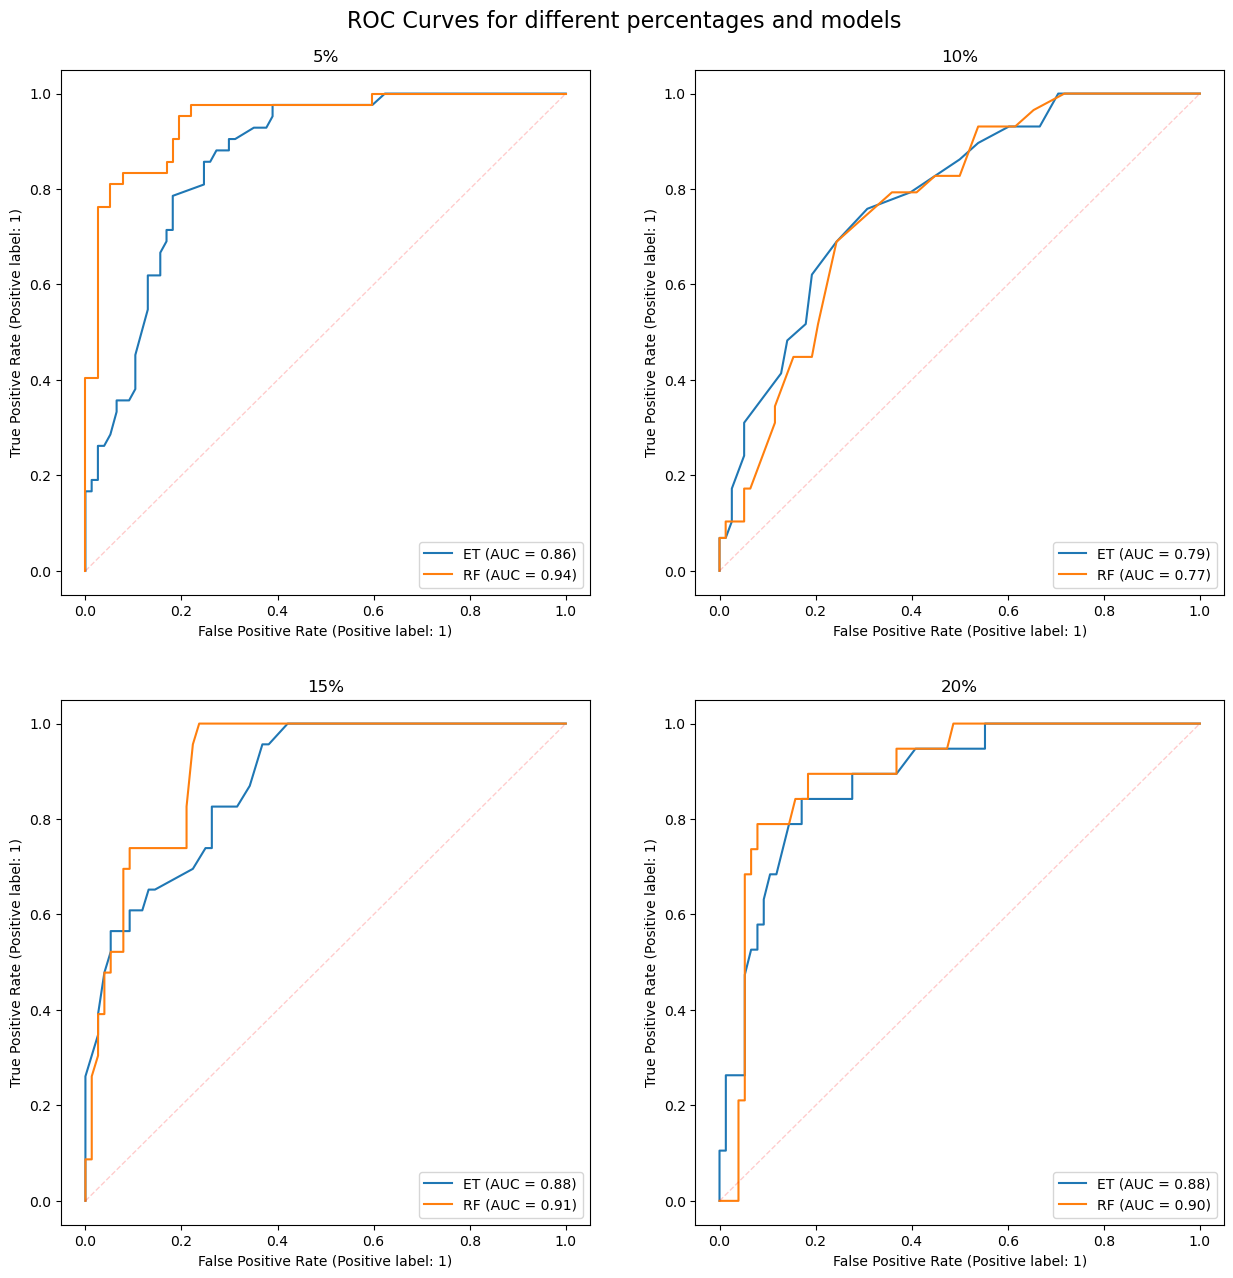

In [8]:
test_pickle = Path('./analysis/pickle_split_test.pkl')

with open(test_pickle, 'rb') as f:
    test_features_at_percentage = pickle.load(f)

plots = {}
# Create a figure and axes with 4 subplots
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
ax = ax.flatten()
# ax = plt.gca()

for i, percentage in enumerate([5, 10, 15, 20]):
    for model in ['ET', 'RF']:
        print(f"Testing {model} at {percentage}%")
        df: pd.DataFrame = preprocess(test_features_at_percentage[percentage])
        df = df.drop(columns=['mzn'], axis=1)
        
        test_X, test_y = df.drop(columns=['solved_within_time_limit']), df['solved_within_time_limit']
        
        y_score = classifiers[(percentage, model)].predict_proba(test_X)[:, 1]
        plots[(percentage, model)] = RocCurveDisplay.from_predictions(test_y, y_score, ax=ax[i], name=model)
    ax[i].set_title(f"{percentage}%")
    ax[i].plot([0, 1], [0, 1], linestyle='--', lw=1, color='r', alpha=.2)

fig.suptitle("ROC Curves for different percentages and models", fontsize=16, y=0.92)

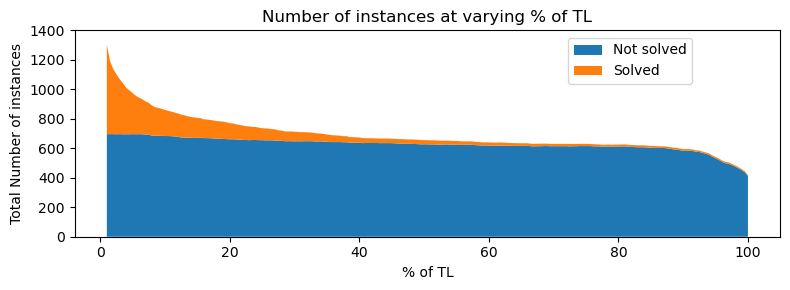

In [9]:
n_total = np.array([train_features_at_percentage[i].shape[0] for i in range(1, len(train_features_at_percentage) + 1)])
n_solved = np.array([train_features_at_percentage[i]['solved_within_time_limit'].sum() for i in range(1, len(train_features_at_percentage) + 1)])
n_not_solved = np.array([n_total[i] - n_solved[i] for i in range(len(n_total))])
percentage_solved = np.array([n_solved[i] / n_total[i] for i in range(len(n_total))]) * 100

x = np.arange(1, 100.5, 0.5)

fig, ax = plt.subplots(figsize=(8, 3))
stacks = ax.stackplot(x, n_not_solved, n_solved, labels=['Not solved', 'Solved'])
ax.set_title("Number of instances at varying % of TL")
ax.set_xlabel("% of TL")
ax.set_ylabel("Total Number of instances")
ax.set_ylim([0, 1400])

fig.legend(loc='upper right', bbox_to_anchor=(0.88, 0.88))
fig.tight_layout()